Lab 3 : Convolutional Neural Networks
=====================================

#### Supervised classification, overfitting and inductive biases in convnets
#### Credit to EEML 2019 ConvNet and Computer Vision tutorial by Viorica Patraucean 
#### Credit to PyTorch model-zoo for ResNet-50 implementation

This practical work introduces you to working with PyTorch and analyzing the training of CNNs.
In particular, you are tasked with the following exercises and questions:

* **Exercise 1: Write PyTorch data Transformers to augment/alter training and testing data with random flips, random crops and random pixel permutations**

* **Exercise 2: Implement and train a Resnet-50 classifier using supervised learning; enable/disable batch norm updates to see the effect.**

* **Exercise 3: Explore the Inductive biases in convnets; comparethe training performance of a convnet with that of a MLP when operating on a randomly permuted image, i.e. one where the bias of locality of information no longer holds.**

* **Exercise 4: Explore the effect of overfitting and regularization using weight decay. Analyze the peformance of a large model, such as ResNet, and the defined MLP on the CIFAR-10 dataset.**

While solving the exercises, provide an answer for the following questions:

**Questions**: 
1. What happens with resnet's performance when batch norm statistics are not updated? How about MLP? Why is one affected less than the other?

2. What is resnet's train loss on permuted cifar? How about the test accuracy? How is the MLP affected by the permutation? What percentage of pixels can be permuted, while still observing an accuracy similar to the one in the normal case?

3. What other types of regularization could you use to avoid overfitting?

### Observation!
Due to the large size of a ResNet-50 model (50 layers) the training time is high. In the lab, you can use a `DOWNSIZE_FACTOR` (set by default to `4`) to reduce the number of channels with which the ResNet model is trained. 
After you have obtained a working implementation, consider training the original ResNet (`DOWNSIZE_FACTOR = 1`) and observe the differences in terms of the questions asked above.

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import time
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'Running code @ {device}')

import numpy as np

# Plotting library.
from matplotlib import pyplot as plt
import pylab as pl
from IPython import display

import collections
import enum
import warnings
warnings.filterwarnings('ignore')

Running code @ cuda


## Download and prepare the data

* Cifar-10 equivalent of MNIST for natural RGB images

* 60000 32x32 colour images in 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

* train: 50000; test: 10000


**TODO Task 1: Implement data augmentation**

In Pytorch one can perform data transformations when loading a dataset using predefined (from `torchvision.transforms`) or custom build _transform_ classes. 
In this exercise you are to augment the _training time_ preprocessing with two data augmentation techniques: random image flips and random crops, which are found in the `torchvision.transforms` package.

In [ ]:
# Prepare data 
import torchvision
import torchvision.transforms as transforms

NUM_WORKERS = 2


TRAIN_DATASET_SIZE = 50000
TEST_DATASET_SIZE = 10000

CIFAR10_IMG_WIDTH = 32
CIFAR10_IMG_HEIGHT = 32

DATA_MEAN = (0.5, 0.5, 0.5)		# define the mean for the scaling transform - PIL images already come given in 
DATA_STD = (0.5, 0.5, 0.5)		# define the standard deviation for the scaling transform
train_transform = transforms.Compose(
    [
        # TODO: apply random horizontal flip
        transforms.RandomHorizontalFlip(),
        # TODO: apply random crop, after padding image with 4 values on each side, using `reflect` mode
        # transforms.RandomCrop(size=[CIFAR10_IMG_HEIGHT / 1.6, CIFAR10_IMG_WIDTH / 1.6], padding=4, padding_mode='reflect'),
        transforms.RandomCrop(size=[CIFAR10_IMG_HEIGHT, CIFAR10_IMG_WIDTH], padding=4, padding_mode='reflect'),
        transforms.ToTensor(),
        transforms.Normalize(DATA_MEAN, DATA_STD)       # normalize the image tensor to [-1, 1] on each channel: img_norm = (img - data_mean) / data_std 
    ] 
)


test_transform = transforms.Compose(
    [
        transforms.ToTensor(),                          # on test set we only need to apply the same normalization
        transforms.Normalize(DATA_MEAN, DATA_STD) 
    ] 
)



train_images = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, 
                                            transform=train_transform)

test_images = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, 
                                           transform=test_transform)

# Check sizes of tensors
print(f'Size of training images {train_images.data.shape}')
print(f'Size of training labels {len(train_images.targets)}')
print(f'Size of test images {test_images.data.shape}')
print(f'Size of test labels {len(test_images.targets)}')


Files already downloaded and verified
Files already downloaded and verified
Size of training images (50000, 32, 32, 3)
Size of training labels 50000
Size of test images (10000, 32, 32, 3)
Size of test labels 10000


## Display the images
The gallery function below shows sample images from the data, together with their labels.

In [ ]:
MAX_IMAGES = 10


def gallery(images, label, title='Input images'):
    class_dict = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    num_frames, h, w, num_channels = images.shape
    num_frames = min(num_frames, MAX_IMAGES)
    ff, axes = plt.subplots(1, num_frames, figsize=(num_frames, 1), subplot_kw={'xticks': [], 
                                                                                'yticks': []})
    for i in range(0, num_frames):
        if num_channels == 3:
            axes[i].imshow(np.squeeze(images[i]))
        else:
            axes[i].imshow(np.squeeze(images[i]), cmap='gray')
        axes[i].set_title(class_dict[label[i]])
        plt.setp(axes[i].get_xticklabels(), visible=False)
        plt.setp(axes[i].get_yticklabels(), visible=False)
    ff.subplots_adjust(wspace=0.1)
    plt.show()


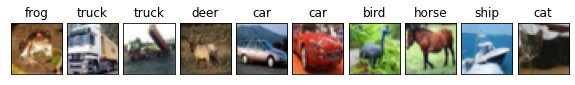

In [ ]:
gallery(train_images.data, train_images.targets)


## Prepare the data for training and testing
* for training, we use stochastic optimizers (e.g. SGD, Adam), so we need to sample at random mini-batches from the training dataset
* for testing, we iterate sequentially through the test set

In [ ]:
# define dimension of the batches to sample from the datasets
BATCH_SIZE_TRAIN = 100  #@param
BATCH_SIZE_TEST = 100  #@param
NO_WORKERS = 8  #@param
SHUFFLE_DATA = True

# create Dataset iterator object using the data previously downloaded
# we shuffle the data and sample repeatedly batches for training
train_loader = torch.utils.data.DataLoader(train_images, batch_size=BATCH_SIZE_TRAIN, 
                                           shuffle=SHUFFLE_DATA, 
                                           num_workers=NO_WORKERS)

# get a training batch of images and labels
(batch_train_images, batch_train_labels) = next(iter(train_loader))

# check that the shape of the training batches is the expected one
print(f'Shape of training images: {batch_train_images.size()}')
print(f'Shape of training labels: {batch_train_labels.size()}')


Shape of training images: torch.Size([100, 3, 32, 32])
Shape of training labels: torch.Size([100])


In [ ]:
# we do the same for test dataset
test_loader = torch.utils.data.DataLoader(test_images, batch_size=BATCH_SIZE_TRAIN, 
                                          shuffle=SHUFFLE_DATA, 
                                          num_workers=NO_WORKERS)

# we define an "infinte" loader for testing, such that we can continuosly sample 100 batches fromt the test set to compute 
# test loss and test accuracy
def loopy_test_loader(dl):
    data_iter = iter(dl)
    
    while True:
        try:
            yield next(data_iter)
        except StopIteration:
            data_iter = iter(dl)
            yield next(data_iter)

(batch_test_images, batch_test_labels) = next(iter(test_loader))
print(f'Shape of test images: {batch_test_images.size()}')
print(f'Shape of test labels: {batch_test_labels.size()}')


Shape of test images: torch.Size([100, 3, 32, 32])
Shape of test labels: torch.Size([100])


## General setting; use the options below to switch between exercises.

In [ ]:
model = "resnet_v2"  # @param['resnet_v2','mlp']
flag_batch_norm = 'ON'  # @param['ON', 'OFF']
flag_permute = False  # @param['True', 'False'] {type:"raw"}
flag_regularize = True  # @param['True', 'False'] {type:"raw"}


## Preprocess input for training and testing

### Random pixel permutation transform

The random pixel permutation transform is used for **Task 3**, analysing the spatial locality inductive bias of CNNs. 
You will have to add this type of transform to the end of the list of data transforms, if `flag_permute` is set to `True`.

In [ ]:
class RandomPermute(object):
    """
    An implementation of a custom PyTorch data transformation class.
    The transform will apply a constant random pixel permutation of the image tensor.
    The permutation is applied to a subset of pixels up to a factor `f` in [0, 1].
    The default is to permute all pixels.
    """
    def __init__(self, width: int = 32, height: int = 32, factor: float = 1.):
        # The constructor of the transformer defines the random subset of pixels to be permuted
        # and the random permutation order of these pixels
        
        # define an initial seed for the random generator to obtain the same random
        # permutation for each image
        rnd_generator = np.random.RandomState(10)
        pixel_coord = np.arange(0, width * height)
        rnd_generator.shuffle(pixel_coord)
        
        # Select pixel coord to permute
        pixel_coord = pixel_coord[:int(factor * len(pixel_coord))]  
        
        # Define permute order
        permute_order = np.arange(0, len(pixel_coord))  
        rnd_generator.shuffle(permute_order)
        
        self.pixel_coord = pixel_coord
        self.permute_order = permute_order

    def __call__(self, image):
        # The __call__ is made for each image tensor 
        pixel_coord = self.pixel_coord
        permute_order = self.permute_order

        image_size = image.size()
        image = image.view(image.size(0), -1)
        # Permute pixels
        image[:, pixel_coord] = image[:, pixel_coord][:, permute_order]
        image = image.view(image_size)
        
        return image


## Defining RESNET-50 Blocks

The PyTorch implementation of ResNet-50 defines 4 logical "layers" of _ResNet block_ groups, which are set up according to the number of channels that result after each logical layer.

The configuration below specifies that there the network is composed of:
  * 3 ResNet blocks with 64 channels and a _"first-block-dimension-reduction-stride"_ of 1
  * 4 ResNet blocks with 128 channels and a _"first-block-dimension-reduction-stride"_ of 2 (halfing the input size)
  * 6 ResNet blocks with 256 channels and a _"first-block-dimension-reduction-stride"_ of 2 (halfing the input size)
  * 3 ResNet blocks with 512 channels and a _"first-block-dimension-reduction-stride"_ of 2 (halfing the input size)


In [ ]:
# define parameters of resnet blocks for resnet-50 model
import collections

ResNetBlockParams = collections.namedtuple(
    "ResNetBlockParams", ["neck_ch", "blocks", "stride"])

DOWNSIZE_FACTOR = 1     # @param[8, 4, 2, 1]

BLOCKS_50 = (
    ResNetBlockParams(int(64/DOWNSIZE_FACTOR), 3, 1),
    ResNetBlockParams(int(128/DOWNSIZE_FACTOR), 4, 2),
    ResNetBlockParams(int(256/DOWNSIZE_FACTOR), 6, 2),
    ResNetBlockParams(int(512/DOWNSIZE_FACTOR), 3, 2)
)


### TODO 2.1: define the convolution operations inside the ResNet-50 block
You have to define the 3x3 and 1x1 convolutions that compose the ResNet-50 block

In [ ]:
def conv3x3(in_planes, out_planes, stride=1, padding=1):
    """
    3x3 2D convolution with padding=1
    @:param in_planes: the number of input channels for the convolution filter
    @:param out_planes: the number of output channels for the convolution filter
    @:param stride: stride value for the convolution filter, default is 1
    @:param padding: the padding to apply, default is 1 to keep width and height the same in the output activation maps 
    """
    return nn.Conv2d(in_channels=in_planes, out_channels=out_planes, kernel_size=3, stride=stride, padding=padding)
    # return nn.Conv2d(...)


def conv1x1(in_planes, out_planes, stride=1):
    """
    1x1 2D convolution
    @:param in_planes: the number of input channels for the convolution filter
    @:param out_planes: the number of output channels for the convolution filter
    @:param stride: stride value for the convolution filter, default is 1
    """
    return nn.Conv2d(in_channels=in_planes, out_channels=out_planes, kernel_size=1, stride=stride)
    # return nn.Conv2d(...)


### TODO 2.2 Define the ResNet block with "bottleneck"

The ResNet-50 _Bottleneck_ block is defined as in the following figure.

![ResNet-50 Bottleneck block](https://github.com/asorici/NN-labs/blob/master/Lab3-CNN/img/Bottleneck-Blocks-for-ResNet-50-left-identity-shortcut-right-projection-shortcut.png?raw=1)

The image on the left displays the case where `stride=1` and the block performs no _downsampling_ of the input because the conv 3x3 on the residual part keeps the same dimensions (using stride=1).

The image on the right shows the operations when `stride=2` and the output of the bottleneck layer is one where _downsampling_ needs to be performed on the input to match the halfing of the image size on the residual path.


In [ ]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 base_width=int(64/DOWNSIZE_FACTOR), norm_layer=nn.BatchNorm2d):
        
        super(Bottleneck, self).__init__()
        
        # `inplanes` defines the initial number of input channels for the bottleneck block
        # `width` encodes the number of filters `f` in the picture of the bottleneck block above 
        width = int(planes * (base_width / (64./DOWNSIZE_FACTOR)))
        # print("==================================================================")
        # print("inplanes", inplanes)
        # print("planes", planes)
        # print("stride", stride)
        # print("downsample", type(downsample))
        # print("base_width", base_width)
        # print("width", width)
        # print("norma_layer", norm_layer)
        # print("==================================================================\n\n\n")
        
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        
        ### YOUR CODE HERE ###
        
        # first conv 1x1 layer which implements the bottlenecking
        # self.conv1 = ...
        self.conv1 = conv1x1(inplanes, width, stride=1)
        # self.bn1 = normalization
        self.bn1 = norm_layer(width)
        
        # conv 3x3 layer which applies the stride given as parameter
        # self.conv2 = ...
        self.conv2 = conv3x3(width, width, stride)
        # self.bn2 = normalization
        self.bn2 = norm_layer(width)
        
        # Conv 1x1 layer where the number of output channels is "expanded" according to the defined expansion factor
        # According to the above figure, the expansion factor is set to 4
        #self.conv3 = ...
        self.conv3 = conv1x1(width, width * self.expansion, stride=1)
        #self.bn3 = normalization
        self.bn3 = norm_layer(width * self.expansion)
        
        ### END CODE ###
        
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x
        ### YOUR CODE HERE ###
        
        # first layer conv1 + bn1 + relu
        # out = ...
        out = self.relu(self.bn1(self.conv1(x)))
        
        # second layer conv2 + bn2 + relu
        # out = ...
        out = self.relu(self.bn2(self.conv2(out)))
        
        # third layer conv3 + bn3
        # out = ...
        out = self.bn3(self.conv3(out))
        
        ### END CODE ###
        
        # apply downsample to identity (original input to block), if it is defined (right image in figure above)
        if self.downsample is not None:
            identity = self.downsample(x)
        
        # add identity to residual and apply relu
        # print(out.shape)
        # print(identity.shape)
        out += identity
        out = self.relu(out)

        return out



### Defining the ResNet-50 model
<div>
	<img title="ResNet-50 Architecture" src="https://github.com/asorici/NN-labs/blob/master/Lab3-CNN/img/ResNet-50-arch.jpg?raw=1" width="300"/>
</div>


In [ ]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=10, base_width=int(64/DOWNSIZE_FACTOR), 
                 norm_layer=nn.BatchNorm2d):
        """
        Build the ResNet network model - based on PyTorch Model Zoo implementation
        
        :param block: the Resnet Block model to be used: in our case the `Bottleneck` block
        :param layers: the logical layer definition, such as the one in BLOCKS_50
        :param num_classes: the number of classes for target labels
        :param base_width: the initial number of layers
        :param norm_layer: the type of normalization to apply - either BatchNorm or EmptyNorm, default is BatchNorm
        """
        super(ResNet, self).__init__()
        self.inplanes = int(64/DOWNSIZE_FACTOR)
        self.dilation = 1
        self._norm_layer = norm_layer
        
        self.base_width = base_width
        
        # ResNet starts out with an initial 7x7 convolution with stride 2 that halves the input size
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)  # image is now 16x16
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        
        # We skip the maxpool layer because it would reduce the size too much starting from a 32 x 32 image 
        # self.maxpool = nn.MaxPool2d(kernel_size=1, stride=1, padding=1)
        
        # -- Build resnet logical layers
        l = layers
        
        # logical layer1 - 3 bottleneck blocks with 64 filters and stride=1 
        self.layer1 = self._make_layer(block, l[0].neck_ch, l[0].blocks, stride=l[0].stride)    # image is 16x16
      
        # logical layer2 - 4 bottleneck blocks with 128 filters and stride=2  (i.e. first halving)
        self.layer2 = self._make_layer(block, l[1].neck_ch, l[1].blocks, stride=l[1].stride)    # image is 8x8
        
        # logical layer3 - 6 bottleneck blocks with 256 filters and stride=2  (i.e. second halving)
        self.layer3 = self._make_layer(block, l[2].neck_ch, l[2].blocks, stride=l[2].stride)    # image is 4x4
        
        # logical layer4 - 3 bottleneck blocks with 512 filters and stride=2  (i.e. third halving)
        self.layer4 = self._make_layer(block, l[3].neck_ch, l[3].blocks, stride=l[3].stride)    # image is 2x2
        
        # final ResNet layers - average pooling reduces size to 1x1 + fully connected layer of size 2048
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc = nn.Linear(int(512/DOWNSIZE_FACTOR) * block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        #print("planes, blocks, stride ", planes, blocks, stride)
        norm_layer = self._norm_layer
        downsample = None

        if stride != 1 or self.inplanes != planes * block.expansion:
            #print("DOWNSAMPLING BECAUSE: ")
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = list()
        
        # first Bottleneck block in the logical layer is the one that does the downsampling 
        layers.append(block(self.inplanes, planes, 
                            stride=stride, downsample=downsample,
                            base_width=self.base_width, 
                            norm_layer=norm_layer))
        
        # the rest operate on the the downsampled result, keeping the size (i.e. using default stride of 1)
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes,
                                base_width=self.base_width,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


In [ ]:
from torchvision.models.resnet import model_urls
from torch.utils.model_zoo import load_url as load_state_dict_from_url

def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch], progress=progress)
        model.load_state_dict(state_dict)
    return model


def resnet50(pretrained=False, progress=True, **kwargs):
    r"""ResNet-50 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, BLOCKS_50, pretrained, progress,
                   **kwargs)


## Define simple MLP baseline

In [ ]:
import torch.nn.functional as F


class MLP(nn.Module):
    def __init__(self, num_classes=10, norm_layer=nn.BatchNorm1d):
        super(MLP, self).__init__()
        in_size = 3 * 32 * 32
        self.fc1 = nn.Linear(in_size, int(1024/DOWNSIZE_FACTOR))
        self.bc1 = norm_layer(int(1024/DOWNSIZE_FACTOR))
        self.fc2 = nn.Linear(int(1024/DOWNSIZE_FACTOR), int(1024/DOWNSIZE_FACTOR))
        self.bc2 = norm_layer(int(1024/DOWNSIZE_FACTOR))
        self.fc3 = nn.Linear(int(1024/DOWNSIZE_FACTOR), num_classes)

    def forward(self, x):
        x = torch.flatten(x, 1)

        x = self.bc1(F.relu(self.fc1(x)))
        x = self.bc2(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x


## Define Empty Normalization Layer

Exercise 2 requires enabling and disabling **batch normalization statistics** to see the effect on training large convolutional models.
Use the `EmptyNorm` layer instead of `nn.BatchNorm2d`/`nn.BatchNorm1d` when required. 

In [ ]:
class EmptyNorm(nn.Module):
    def __init__(self, *args, **kwargs):
        super(EmptyNorm, self).__init__()
        self._modules = dict()
    
    def forward(self, input):
        # simply pass input "as is" to the output of the layer
        return input

## Set up training pipeline

In [ ]:
# First define the preprocessing ops for the train/test data
crop_height = 32  # @param 
crop_width = 32  # @param
NUM_CLASSES = 10  # @param


### Initialize network & Get predictions from either MLP baseline or convnet

#### Note:
**For exercise 3, change `flag_permute` to `True`, to add random permutations of the pixels in train and test set images. Analyze the performance of ResNet and MLP in each case.**

In [ ]:
blocks = BLOCKS_50

net = None  # type: nn.Module


if model == 'mlp':
    if flag_batch_norm == "ON":
        net = MLP(num_classes=NUM_CLASSES)
    else:
        net = MLP(num_classes=NUM_CLASSES, norm_layer=EmptyNorm)
        
else:  # model is resnet_v2
    if flag_batch_norm == "ON":
        net = resnet50(num_classes=NUM_CLASSES)
    else:
        net = resnet50(num_classes=NUM_CLASSES, norm_layer=EmptyNorm)

# Add the RandomPermute transform to the end of each pre-processing pipeline in train and test image dataset loaders.
if flag_permute:
    permute_transform = RandomPermute()
    train_images.transform.transforms.append(permute_transform)
    test_images.transform.transforms.append(permute_transform)


net.train()  # Default after init is train mode
net = net.to(device)  # Move network to device

# Let us print the network architecture that we have defined
print(list(net.modules())[0])

# Let us test that we can propagate a batch through the defined networks
select = 2
inputs = batch_train_images.to(device)[:select]
target = batch_train_labels[:select]

output = net(inputs)
_, predicted = torch.max(output, 1)

print(output)
print(predicted)
print(target)


planes, blocks, stride  16 3 1
DOWNSAMPLING BECAUSE: 
inplanes 16
planes 16
stride 1
downsample <class 'torch.nn.modules.container.Sequential'>
base_width 16
width 16
norma_layer <class 'torch.nn.modules.batchnorm.BatchNorm2d'>



inplanes 64
planes 16
stride 1
downsample <class 'NoneType'>
base_width 16
width 16
norma_layer <class 'torch.nn.modules.batchnorm.BatchNorm2d'>



inplanes 64
planes 16
stride 1
downsample <class 'NoneType'>
base_width 16
width 16
norma_layer <class 'torch.nn.modules.batchnorm.BatchNorm2d'>



planes, blocks, stride  32 4 2
DOWNSAMPLING BECAUSE: 
inplanes 64
planes 32
stride 2
downsample <class 'torch.nn.modules.container.Sequential'>
base_width 16
width 32
norma_layer <class 'torch.nn.modules.batchnorm.BatchNorm2d'>



inplanes 128
planes 32
stride 1
downsample <class 'NoneType'>
base_width 16
width 32
norma_layer <class 'torch.nn.modules.batchnorm.BatchNorm2d'>



inplanes 128
planes 32
stride 1
downsample <class 'NoneType'>
base_width 16
width 32
norma_la

In [ ]:
# Get number of parameters in a model by iterating through the model parameters
def get_num_params(model):
    num_params = 0
    for params in model.parameters():
        num_params += params.shape.numel()
        
    return num_params


In [ ]:
# Get number of parameters in the model. Verify that we have implemented models correctly
print("Total number of parameters of models")
print(str(net.__class__), ": ", get_num_params(net))  

# should be on the order of 23M for default ResNet and 4M for default MLP (i.e. DOWNSIZE_FACTOR = 1)
# if scaled down by 4: 1.4M for ResNet, 856K for MLP (i.e. DOWNSIZE_FACTOR = 4)



Total number of parameters of models
<class '__main__.ResNet'> :  1492730


### Define the top_k accuracy measure

In [ ]:
def top_k_accuracy(k, target, output):
    batch_size = target.size(0)
    
    _, pred = output.topk(k, 1, True, True)
    
    pred = pred.t()
    correct = pred.eq(target.to(device).view(1, -1).expand_as(pred))

    correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
    correct_k.mul_(100.0 / batch_size)
    
    return correct_k


### Setup training parameters

For **Exercise 4** set `flag_reqularize` to `True`. 
Play with the type of optimizer to see the difference between Adam and SGD-Momentum on training speed/accuracy.

The code below also showcases how one can define _learning rate decay schedules_. In this particular case, the learning rate is decayed by a factor, after having reached specific iteration milestones.

In [ ]:
lr_init = 0.01              # initial learning rate
lr_factor = 0.1             # learning rate decay factor
weight_decay_factor = 1e-4  # weight decay factor for L2 weight regularization
lr_schedule_milestones = [90e3, 100e3, 110e3]

# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Define optimizer - SGD with momentum and weight_decay for L2 weight regularization
#optimizer = torch.optim.SGD(net.parameters(), lr=lr_init, momentum=0.9, weight_decay=weight_decay_factor)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

if flag_regularize:
    #optimizer = torch.optim.SGD(net.parameters(), lr=lr_init, momentum=0.9, weight_decay=weight_decay_factor)
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01, weight_decay=weight_decay_factor)
    
    
# Define learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=lr_schedule_milestones, gamma=lr_factor)

In [ ]:
# Function that takes a list of losses and plots them.
REFRESH_EVERY = 1000

def plot_losses(loss_list, steps, ct):
    if ct % REFRESH_EVERY == 0:
        display.clear_output(wait=True)
    
    display.display(pl.gcf())
    pl.plot(steps, loss_list, c='b')
    time.sleep(1.0)

### Define reporting parameters

In [ ]:
# Define number of training iterations and reporting intervals
TRAIN_ITERS = 100e3  # @param
REPORT_TRAIN_EVERY = 100  # @param
PLOT_EVERY = 100  # @param
REPORT_TEST_EVERY = 200  # @param
TEST_ITERS = 100  # @param

## Training the model

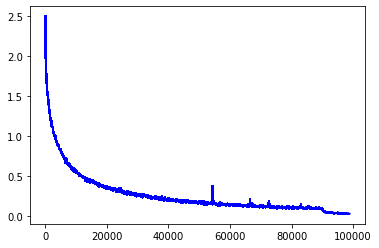

[199,   100,  99099] LR: 0.00100
[199,   100] loss: 0.03059, acc: 89698.28906


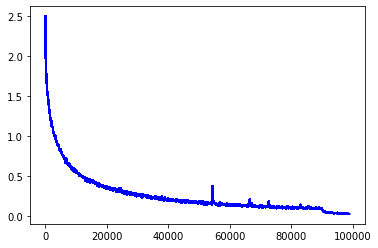

[199,   200,  99199] LR: 0.00100
[199,   200] loss: 0.03151, acc: 89797.25781
[199,   200] avg_test_loss: 0.46862, avg_test_acc: 90.14


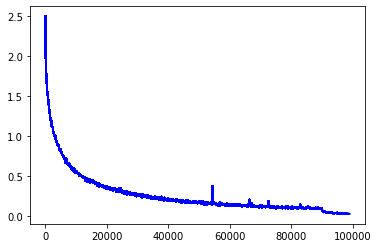

[199,   300,  99299] LR: 0.00100
[199,   300] loss: 0.03194, acc: 89896.10156


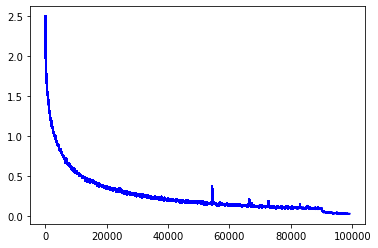

[199,   400,  99399] LR: 0.00100
[199,   400] loss: 0.03344, acc: 89994.90625
[199,   400] avg_test_loss: 0.47000, avg_test_acc: 90.03


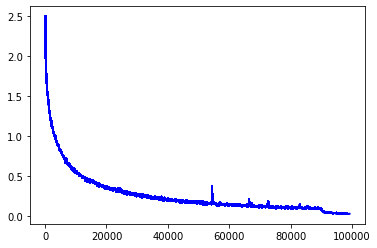

[199,   500,  99499] LR: 0.00100
[199,   500] loss: 0.03292, acc: 90093.71875
epoch, total 199 200


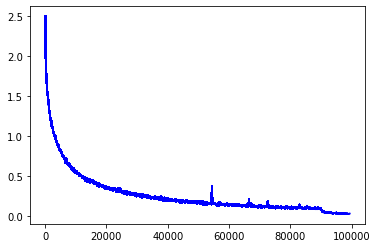

[200,   100,  99599] LR: 0.00100
[200,   100] loss: 0.03120, acc: 90192.57031
[200,   100] avg_test_loss: 0.47326, avg_test_acc: 90.17


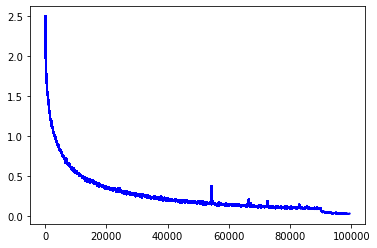

[200,   200,  99699] LR: 0.00100
[200,   200] loss: 0.03145, acc: 90291.54688


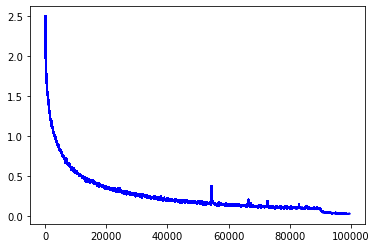

[200,   300,  99799] LR: 0.00100
[200,   300] loss: 0.02814, acc: 90390.60156
[200,   300] avg_test_loss: 0.47252, avg_test_acc: 90.07


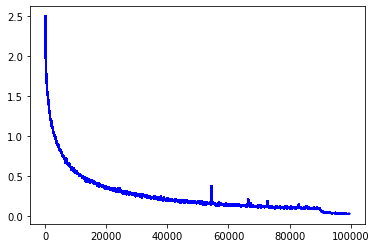

[200,   400,  99899] LR: 0.00100
[200,   400] loss: 0.02839, acc: 90489.48438


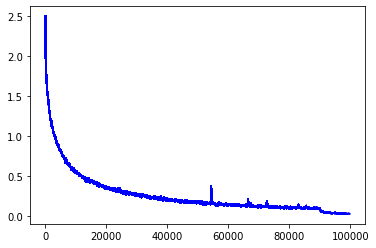

[200,   500,  99999] LR: 0.00001
[200,   500] loss: 0.02681, acc: 90588.46875
[200,   500] avg_test_loss: 0.47058, avg_test_acc: 90.06
Finished Training


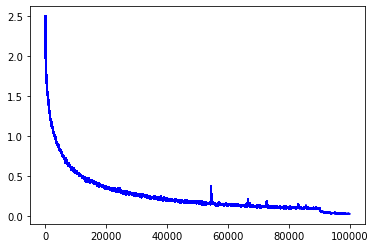

In [ ]:
# Question: What is the accuracy of the model at iteration 0, i.e. before training starts?

EPOCHS = int(TRAIN_ITERS / (TRAIN_DATASET_SIZE / BATCH_SIZE_TRAIN))

train_iter = 0
losses = []
steps = []



test_data_provider = loopy_test_loader(test_loader)

# set model in train mode
net.train()

running_loss = 0.0
running_acc = 0.0
ct = 0

for epoch in range(int(EPOCHS)):  # loop over the dataset multiple times
    print("epoch, total", epoch, EPOCHS)
    for i, data in enumerate(train_loader, 0):
        # set the learning rate and decay according to iteration schedule
        lr_scheduler.step()
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        running_acc += top_k_accuracy(1, labels, outputs)
        
        if train_iter % REPORT_TRAIN_EVERY == REPORT_TRAIN_EVERY - 1:    # print every REPORT_TRAIN_EVERY mini-batch iterations
            train_loss = running_loss / REPORT_TRAIN_EVERY
            train_acc = running_acc / REPORT_TRAIN_EVERY
            
            print('[%d, %5d, %6d] LR: %.5f' % (epoch + 1, i + 1, train_iter, lr_scheduler.get_lr()[-1]))
            print('[%d, %5d] loss: %.5f, acc: %.5f' %
                  (epoch + 1, i + 1, train_loss, train_acc))
            
            losses.append(train_loss)
            steps.append(train_iter)
            
            running_loss = 0
            train_loss = 0
            
            
        if train_iter % PLOT_EVERY == 0:
            plot_losses(losses, steps, train_iter)
            
        train_iter += 1
    
        if train_iter % REPORT_TEST_EVERY == 0:
            # set model in test mode
            net.eval()
            
            with torch.no_grad():
                # evaluate over at most TEST_ITER sub samples from the test_loader
                test_iter = 0
                test_loss = 0
                correct = 0
                
                while test_iter < TEST_ITERS:
                #for j, test_data in enumerate(test_loader, start=test_ct):
                    test_data = next(test_data_provider)
                        
                    # get the test inputs; data is a list of [inputs, labels]
                    test_inputs, test_labels = test_data[0].to(device), test_data[1].to(device)
                    
                    out = net(test_inputs)
                    test_loss += criterion(out, test_labels)
                    
                    correct += top_k_accuracy(1, test_labels, out)
                    
                    test_iter += 1
                    
                avg_test_loss = test_loss / TEST_ITERS
                avg_acc = correct / TEST_ITERS
                
                print('[%d, %5d] avg_test_loss: %.5f, avg_test_acc: %.2f' 
                    % (epoch + 1, i + 1, avg_test_loss, avg_acc))
                
            # set model back in train mode
            net.train()
    
print('Finished Training')

In [ ]:
# Answers:

#1 If the batch norm statistics are not updated, the ResNet's performance decreases.
#  This doesn't seem to impact the MLP too much, maybe because it has only a few layers anyways. 

#2 It seems the training accuracy is >90%, but the test accuracy is about half.
#  So the spatial information is important to the ResNet, but the MLP is not really affected, because of the FC layers maybe.

#3 Early stopping or dropout layers

In [ ]:
# test_data_provider = loopy_test_loader(test_loader)
# test_data = next(test_data_provider)
# test_inputs, test_labels = test_data[0].to(device), test_data[1].to(device)
# out = net(test_inputs)
# print(out)